#### Eduardo Badillo Á A01020716
#### Rafael Díaz Medina A01024592
#### Moisés Uriel Torres A01021323
#### Ernesto Ramírez
### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import time
import psutil

## Import and analyze data

In [2]:
df = pd.read_csv("Averaged_BearingTest_Dataset.csv")
print("dataset shape",df.shape)
print(df.tail())

dataset shape (982, 2)
           datetime  Bearing1
977  2/19/2004 5:42  0.453335
978  2/19/2004 5:52  0.337583
979  2/19/2004 6:02  0.351111
980  2/19/2004 6:12  0.001857
981  2/19/2004 6:22  0.001168


In [3]:
from datetime import datetime

# parse date strings to datetime
df['datetime'] = [datetime.strptime(dt, "%m/%d/%Y %H:%M") for dt in df['datetime']]

In [4]:
df.dtypes

datetime    datetime64[ns]
Bearing1           float64
dtype: object

In [5]:
df['Bearing1'].describe()

count    982.000000
mean       0.080951
std        0.040200
min        0.001168
25%        0.060773
50%        0.062021
75%        0.083277
max        0.453335
Name: Bearing1, dtype: float64

#### duration of monitoring

In [6]:
dur_recording = max(df['datetime']) - min(df['datetime'])
print("this monitor duration is exactly: ",dur_recording)

this monitor duration is exactly:  6 days 19:30:00


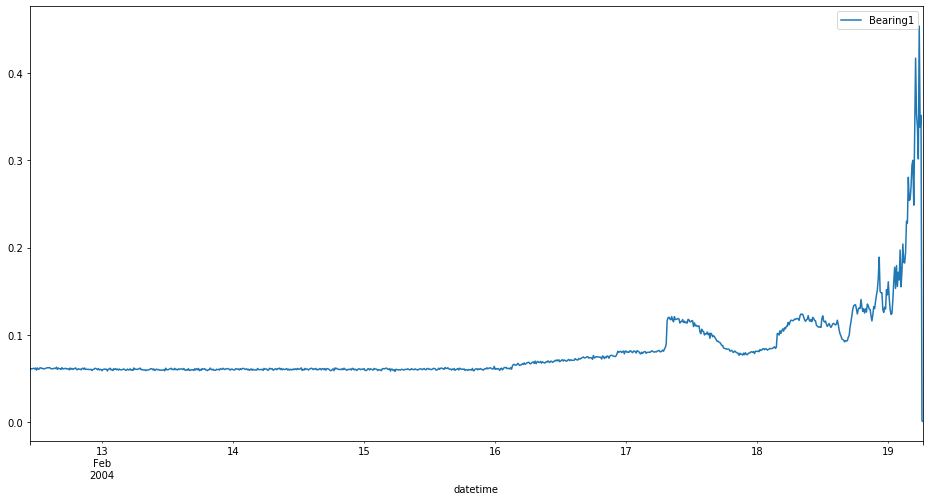

In [7]:
df.plot(x='datetime', y='Bearing1', kind="line", figsize=(16,8))
plt.show()

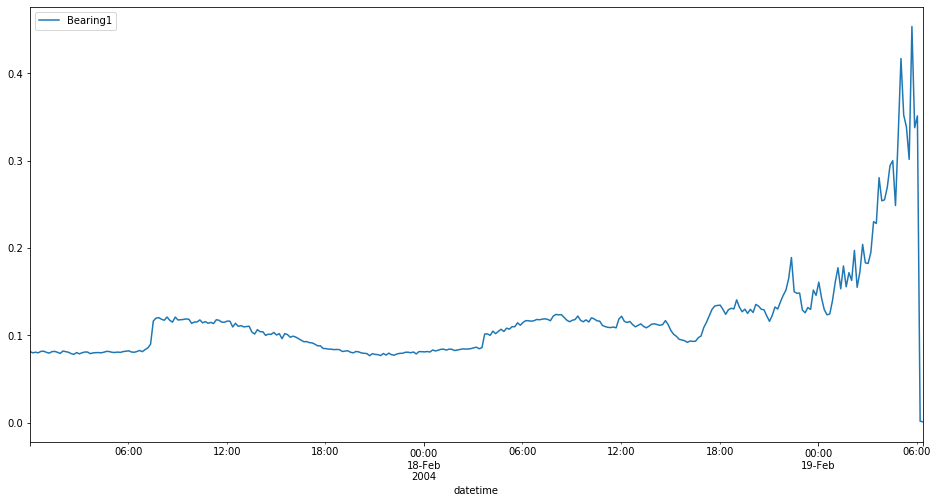

In [8]:
## zoom-in in anomalies
df2 = df.copy()
df2.set_index('datetime', inplace=True)
df2['2004-02-17':'2004-02-19'].plot(kind="line", figsize=(16,8))
plt.show()

We can observe that anomalies start around 7:00 am the 17 of February, 2004

## LSTM RNN

#### Data transformation

In [9]:
# obtain timestamp from datetime, set as index
df2['ts'] = df2.index.values.astype(np.int64) // 10 ** 9 
df2.set_index('ts', inplace=True)

# Split dataset into train and set with given percentages
dataset = df2.values
train_len = round(0.8*len(dataset))
dataset_len = len(dataset)
print("Length of training set:", train_len)

train, test = dataset[0:train_len, :], dataset[train_len:dataset_len, :]

Length of training set: 786


This model doesn't require an (X,y) interaction, because it uses __y(t-delta)__ to predict __y(t)__ <br> 
Where delta is the lookback integer that represents the time steps we will take back.
<br><br>
That is why we add __y+lookback__ steps as our y_train

In [10]:
# Lookback is set as 1 by default
def prepare(ds, lookback=1):
    x, y = [], []
    
    for i in range(len(ds) - lookback-1):
        temp = ds[i: (i+lookback), 0] # 
        x.append(temp)
        y.append(ds[i+lookback, 0]) # 
        
    return np.array(x), np.array(y)

# Pass in train and test sets
x_train, y_train = prepare(train)
x_test, y_test = prepare(test)

# Reshape into format (samples, timesteps, features)
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

#### Create and compile LSTM model

In [12]:
from keras.layers import Dense, LSTM
from keras.models import Sequential 
look_back = 1
model = Sequential()

# input shape: (look_back steps, number of features)
model.add(LSTM(units=4, input_shape=(look_back, 1)))

#model.add(LSTM(units=32, return_sequences=False, dropout= 0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


First, we will use a simple RNN with a single hidden layer and 4 neurons (not counting the output) to test.

#### Train Model

We will test how our model's learning ability changes as we vary validation splits

In [13]:
# Iterate through set of validation splits, train the model and get its history callback
val_splits = [0.1,0.2, 0.25, 0.35]
arr_callbacks = []

for v in val_splits:
    arr_callbacks.append(model.fit(X_train, y_train, epochs=20, verbose=0, batch_size=1, validation_split=v))


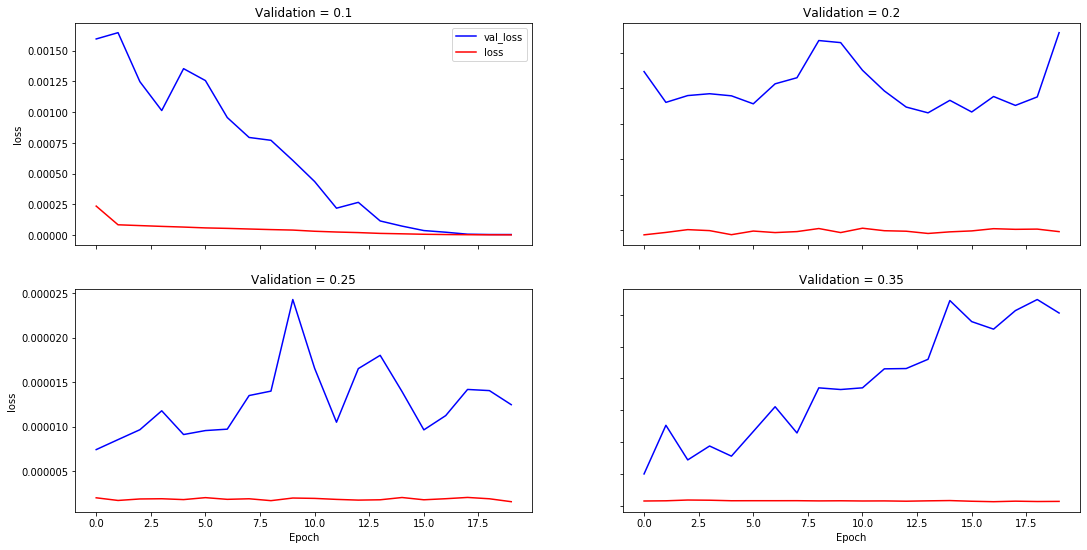

In [14]:
fig, axs = plt.subplots(2,2, figsize=(18,9))

axs[0,0].plot(arr_callbacks[0].history['val_loss'], color='b', label='val_loss')
axs[0,0].plot(arr_callbacks[0].history['loss'], color='r', label='loss')
axs[0,0].set_title('Validation = 0.1')

axs[0,1].plot(arr_callbacks[1].history['val_loss'], color='b', label='val_loss')
axs[0,1].plot(arr_callbacks[1].history['loss'], color='r', label='loss')
axs[0,1].set_title('Validation = 0.2')

axs[1,0].plot(arr_callbacks[2].history['val_loss'], color='b', label='val_loss')
axs[1,0].plot(arr_callbacks[2].history['loss'], color='r', label='loss')
axs[1,0].set_title('Validation = 0.25')

axs[1,1].plot(arr_callbacks[3].history['val_loss'], color='b', label='val_loss')
axs[1,1].plot(arr_callbacks[3].history['loss'], color='r', label='loss')
axs[1,1].set_title('Validation = 0.35')

axs[0,0].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='loss')

for ax in axs.flat:
    ax.label_outer()

plt.show()

Observation: We can see that as validation split increases, the validation loss MSE increases too. <br>
With smaller proportions of the validation data, val_loss and loss tend to converge as more epochs go by <br>
With larger proportions of the validation data, val loss and loss tend to diverge as we see with validation=0.35 <br>
This is largely intuitive, because we have less data for the model to train with and hence its ability to generalize decreases. <br> So it will be in our benefit to use the model with the least validation split.

#### Sequential Experiments

Now we will vary layers and node configuration in the RNN to find an optimal combination

In [15]:
# auxiliary function to return the number of neurons in an ANN
def get_total_number_of_neurons(model, include_output_layer):
    num_layers = len(model.layers)
    total_num_of_neurons = 0
    for layer_index in range(num_layers):
        layer = model.layers[layer_index]
        # since we multiply layer output dimensions, initial value is set to 1.
        num_neurons_in_layer = 1
        for i in range(1, len(layer.output.shape)):
            try:
                # when it is a valid layer to count neurons, an output dimension of the layer can be convertible to int.
                num_neurons_in_layer *= int(layer.output.shape[i])
            except Exception:
                # if the output dimension of layer cannot be convertible to int,
                # just pass that layer since it is not a valid layer to count neurons
                pass
        # if num_neurons_in_layer is not still 1, it means we have a valid layer to count neurons
        if not num_neurons_in_layer == 1:
            # when it is an output layer
            if layer_index == (num_layers - 1):
                if include_output_layer:
                    total_num_of_neurons += num_neurons_in_layer
            else:  # when it is not an output layer
                total_num_of_neurons += num_neurons_in_layer
    return total_num_of_neurons

In [16]:
# Function to create a RNN with a dynamic number of layers and nodes
def create_model(name, nodes=4, layers=1, pr=0):
    
    new_model = Sequential()
    
    # return_sequences = False
    new_model.add(LSTM(units=nodes, input_shape=(look_back, 1)))
    
    # next hidden layers aren´t LSTM layers
    if(layers>1):
        for l in range(2, layers+1):
            new_model.add(Dense(units=nodes, activation='relu'))

    # output layer
    new_model.add(Dense(1))

    new_model.compile(optimizer='adam', loss='mean_squared_error')

    if(pr):
        print(new_model.summary())
        
    if(name):
        new_model.name = name
    
    return new_model

In [17]:
model_1 = create_model("m_1", 10, 1, 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# Create list of compiled models
model_list = [model_1]
for n_nodes in np.arange(20,110, 10):
    model_name = "m_" + str(n_nodes/10)
    model_list.append(create_model(model_name, n_nodes, 1, 0))

m_dict = {}

# Train each model
for m in model_list:
    
    # time the training 
    t0 = time.time()
    m.fit(X_train, y_train, epochs=20, verbose=0, batch_size=1)
    t1 = time.time()
    
    # time the prediction time 
    t2 = time.time()
    train_predict = m.predict(X_train)
    test_predict = m.predict(X_test)
    t3 = time.time()
    
    # create dictionary for dataframe
    m_dict[m.name] = {"layers": len(m.layers),
                     "nodes": get_total_number_of_neurons(m, False),
                     "train_RMSE": math.sqrt(mean_squared_error(y_train, train_predict)),
                     "test_RMSE": math.sqrt(mean_squared_error(y_test, test_predict)),
                     "train_time": t1-t0,
                     "predict_time":t3-t2,
                     "cpu_usage": psutil.cpu_percent()}

In [19]:
dict_df = pd.DataFrame(m_dict).T
dict_df

,layers,nodes,train_RMSE,test_RMSE,train_time,predict_time,cpu_usage
m_1,2.0,10.0,0.002985,0.034385,19.518974,0.199046,12.8
m_2.0,2.0,20.0,0.008507,0.035709,19.551415,0.212047,22.3
m_3.0,2.0,30.0,0.001633,0.033496,19.809474,0.244056,24.6
m_4.0,2.0,40.0,0.001725,0.033367,20.177199,0.264059,25.0
m_5.0,2.0,50.0,0.002126,0.033673,20.329592,0.284064,24.9
m_6.0,2.0,60.0,0.001753,0.033448,21.079762,0.312069,24.6
m_7.0,2.0,70.0,0.001889,0.032795,22.298559,0.328074,24.2
m_8.0,2.0,80.0,0.001633,0.033818,22.784144,0.352080,24.0
m_9.0,2.0,90.0,0.003099,0.034007,23.971663,0.372084,24.0
m_10.0,2.0,100.0,0.002357,0.033355,24.536541,0.393089,23.8


Even with a very simple configuration of 10 nodes with a single hidden layer and an output layer, we are seeing a very optimal performance. Adding nodes by increments of 10 slightly increases performance. We will see this graphically in the following plots. 

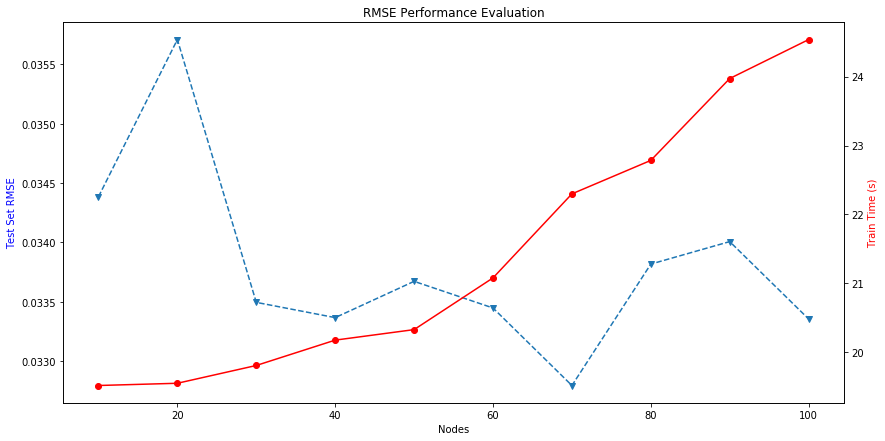

In [20]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(dict_df['nodes'], dict_df['test_RMSE'], marker="v", linestyle="--")

ax.set_title("RMSE Performance Evaluation")
ax.set_xlabel("Nodes")
ax.set_ylabel("Test Set RMSE", color='blue')

ax2 = ax.twinx()
ax2.plot(dict_df['nodes'], dict_df['train_time'], marker='o', color='r')
ax2.set_ylabel("Train Time (s)", color='red')


plt.show()

Observations: The configurations that have the least RMSE are the networks with 40 and 70 nodes. But the 70 node network is the best overall given that it has the least RMSE test set score. However its train time is higher than the 40 node network by about 2 seconds. This is a small difference, but it can grow on larger datasets proportionately. Given that time is not a priority on our model production, we can safely choose the 70 node network. 

### Changing look_back settings

We will see how taking wider gaps between our observations and predictions alter our model's performance by varying the look_back of the data transformation and the model input.

In [21]:
def lstm_1layer(look_back=1, pr=0):
    # Pass in train and test sets
    x_train, y_train = prepare(train, look_back)
    x_test, y_test = prepare(test, look_back)

    # Reshape into format (samples, timesteps, features)
    X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    model_l1 = Sequential()

    # input shape: (look_back steps, number of features)
    model_l1.add(LSTM(units=4, input_shape=(1, look_back)))

    #model.add(LSTM(units=32, return_sequences=False, dropout= 0.2))

    model_l1.add(Dense(1))

    model_l1.compile(optimizer='adam', loss='mean_squared_error')
    
    if(pr):
        print(model_l1.summary())
        
    return X_train, y_train, X_test, y_test, model_l1

# transform data and create model
X_train_1, y_train_1, X_test_1, y_test_1, model_1 = lstm_1layer(10,0)
X_train_2, y_train_2, X_test_2, y_test_2, model_2 = lstm_1layer(20,0)
X_train_3, y_train_3, X_test_3, y_test_3, model_3 = lstm_1layer(30,0)
X_train_4, y_train_4, X_test_4, y_test_4, model_4 = lstm_1layer(40,0)
X_train_5, y_train_5, X_test_5, y_test_5, model_5 = lstm_1layer(50,0)

# train and feed the data to the model
h1_callback = model_1.fit(X_train_1, y_train_1, epochs=20, verbose=0, batch_size=1, validation_split=0.10)
h2_callback = model_2.fit(X_train_2, y_train_2, epochs=20, verbose=0, batch_size=1, validation_split=0.10)
h3_callback = model_3.fit(X_train_3, y_train_3, epochs=20, verbose=0, batch_size=1, validation_split=0.10)
h4_callback = model_4.fit(X_train_4, y_train_4, epochs=20, verbose=0, batch_size=1, validation_split=0.10)
h5_callback = model_5.fit(X_train_5, y_train_5, epochs=20, verbose=0, batch_size=1, validation_split=0.10)


In [22]:
# Get averages for validation and train loss 
avg_h1_val, avg_h1_tr = np.mean(h1_callback.history['val_loss']), np.mean(h1_callback.history['loss'])
avg_h2_val, avg_h2_tr = np.mean(h2_callback.history['val_loss']), np.mean(h2_callback.history['loss'])
avg_h3_val, avg_h3_tr = np.mean(h3_callback.history['val_loss']), np.mean(h3_callback.history['loss'])
avg_h4_val, avg_h4_tr = np.mean(h4_callback.history['val_loss']), np.mean(h4_callback.history['loss'])
avg_h5_val, avg_h5_tr = np.mean(h5_callback.history['val_loss']), np.mean(h5_callback.history['loss'])

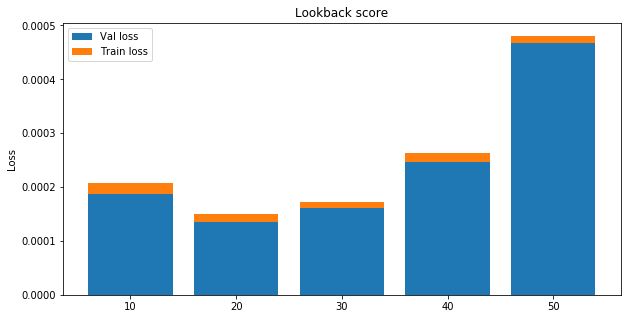

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

avg_val = [avg_h1_val, avg_h2_val, avg_h3_val, avg_h4_val, avg_h5_val]
avg_tr = [avg_h1_tr, avg_h2_tr, avg_h3_tr, avg_h4_tr, avg_h5_tr]
list_lb = ['10', '20','30', '40', '50']

ax.bar(list_lb, avg_val, label='Val loss')
ax.bar(list_lb, avg_tr, bottom=avg_val, label='Train loss')
ax.set_ylabel('Loss')
ax.set_title("Lookback score")
ax.legend()
plt.show()

Observation: We can observe that, in average, the train and loss functions do increase as look_back increases. That is except for look_back = 10 that is above the 20 and 30 setting for the validation loss. But we can expect results like this, given that as we look further back into our y-look_back more variate and less accurate we can expect as we take into account more and more datapoints. This can not always be the case, as certainly it can happen that at larger look_back settings the loss can decrease as well. Even if our current look_back = 50 model performed the poorest, its actual validation loss is very small. Its only larger in comparison to our other models.

In [24]:
test_predict_10 = model_1.predict(X_test_1)
testScore_10 = math.sqrt(mean_squared_error(y_test_1, test_predict_10))
print('Test Score with 10 look_back: %.2f RMSE' % (testScore_10))

test_predict_50 = model_5.predict(X_test_5)
testScore_50 = math.sqrt(mean_squared_error(y_test_5, test_predict_50))
print('Test Score with 50 look_back: %.2f RMSE' % (testScore_50))

Test Score with 10 look_back: 0.04 RMSE
Test Score with 50 look_back: 0.04 RMSE


Our test score RMSE with the minimal and maximal look_back settings remains almost the same and they both have a high performance.

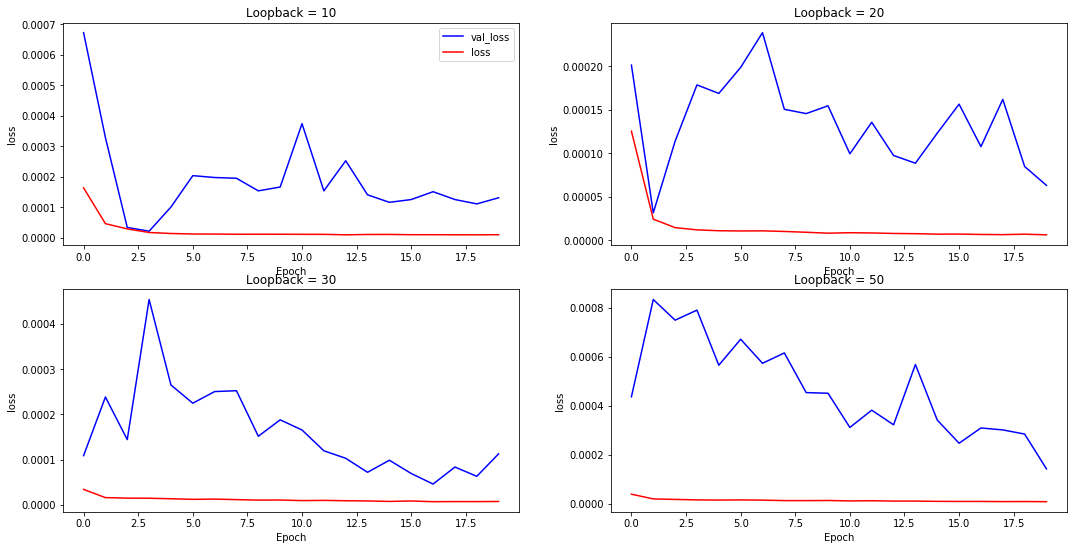

In [25]:
fig, axs = plt.subplots(2,2, figsize=(18,9))

axs[0,0].plot(h1_callback.history['val_loss'], color='b', label='val_loss')
axs[0,0].plot(h1_callback.history['loss'], color='r', label='loss')
axs[0,0].set_title('Loopback = 10')

axs[0,1].plot(h2_callback.history['val_loss'], color='b', label='val_loss')
axs[0,1].plot(h2_callback.history['loss'], color='r', label='loss')
axs[0,1].set_title('Loopback = 20')

axs[1,0].plot(h3_callback.history['val_loss'], color='b', label='val_loss')
axs[1,0].plot(h3_callback.history['loss'], color='r', label='loss')
axs[1,0].set_title('Loopback = 30')

axs[1,1].plot(h5_callback.history['val_loss'], color='b', label='val_loss')
axs[1,1].plot(h5_callback.history['loss'], color='r', label='loss')
axs[1,1].set_title('Loopback = 50')

axs[0,0].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='loss')


plt.show()

Plotting the look_back in its different settings, we can confirm that no matter which we choose the loss functions still is returning good differences. If we would like optimal performance with the least loss we can choose look_back 20

### Finally, plot the prediction

In [26]:
model_try = create_model("m_proto", 10, 2, 1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
h_callback = model_try.fit(X_train, y_train, epochs=20, verbose=1, batch_size=1, validation_split=0.15)

Train on 666 samples, validate on 118 samples
Epoch 1/20
666/666 [==============================] - 2s 3ms/step - loss: 5.0944e-05 - val_loss: 6.5764e-04
Epoch 2/20
666/666 [==============================] - 1s 2ms/step - loss: 2.5368e-05 - val_loss: 8.4256e-04
Epoch 3/20
666/666 [==============================] - 1s 2ms/step - loss: 2.1440e-05 - val_loss: 5.5053e-04
Epoch 4/20
666/666 [==============================] - 1s 2ms/step - loss: 1.7078e-05 - val_loss: 2.1607e-04
Epoch 5/20
666/666 [==============================] - 1s 2ms/step - loss: 1.1188e-05 - val_loss: 2.3442e-04
Epoch 6/20
666/666 [==============================] - 1s 2ms/step - loss: 7.3846e-06 - val_loss: 7.3443e-05
Epoch 7/20
666/666 [==============================] - 1s 2ms/step - loss: 3.2410e-06 - val_loss: 3.5490e-05
Epoch 8/20
666/666 [==============================] - 1s 2ms/step - loss: 3.2431e-06 - val_loss: 2.9503e-05
Epoch 9/20
666/666 [==============================] - 1s 2ms/step - loss: 3.1900e-06 - val

#### Evaluate performance with validation splits

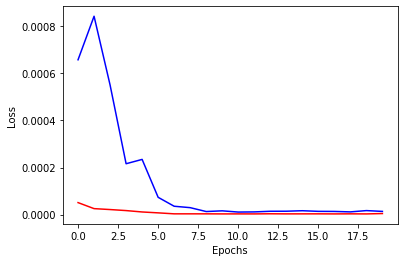

In [28]:
plt.plot(h_callback.history['val_loss'], 'b', h_callback.history['loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Test model with test set

In [29]:
train_predict = model_try.predict(X_train)
test_predict = model_try.predict(X_test)

In [30]:
trainPlot = np.empty_like(dataset)
trainPlot[:,:] = np.nan
trainPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPlot = np.empty_like(dataset)
testPlot[:,:] = np.nan
testPlot[len(train_predict) + (look_back * 2) + 1 : len(dataset) - 1, :] = test_predict

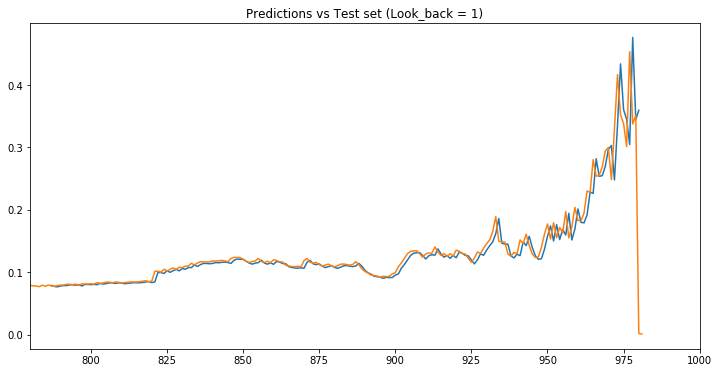

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(testPlot)
ax.plot(dataset)
ax.set_xlim([780, 1000])
ax.set_title("Predictions vs Test set (Look_back = 1)")
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.03 RMSE


We can see from the plot and the RMSE, that the prediction is very close to the actual data. Perhaps, there is a little bit of overfitting, given that the train score RMSE is none, and the test score elevates. Given the small dataset provided, we cannot test the model's ability to generalize any further. But we can be confident on its result with this separated test set. <br>

# Arima Model

In [33]:
df3 = df.copy()
df3.head()

,datetime,Bearing1
0,2004-02-12 10:52:00,0.060236
1,2004-02-12 11:02:00,0.061455
2,2004-02-12 11:12:00,0.061361
3,2004-02-12 11:22:00,0.061665
4,2004-02-12 11:32:00,0.061944


#### Data transformation

For our arima model, we don't have to convert the predictor data to a special format, with datetime is enough.

In [34]:
from sklearn.model_selection import train_test_split

# Set index to type of 'DatetimeIndex',
df3.index = pd.to_datetime(df3.datetime)
df3.drop(['datetime'], inplace=True, axis=1)
print(df3.head())
print(df3.dtypes)

'''
Split dataset into train and set with given percentages
dataset = df3.values
train_len = round(0.8*len(dataset))
dataset_len = len(dataset)

print("Length of training set:", train_len)

arima_train, arima_test = dataset[0:train_len, :], dataset[train_len:dataset_len, :]
'''

arima_train, arima_test = train_test_split(df3, test_size = 0.2, train_size = 0.8, shuffle=False)


                     Bearing1
datetime                     
2004-02-12 10:52:00  0.060236
2004-02-12 11:02:00  0.061455
2004-02-12 11:12:00  0.061361
2004-02-12 11:22:00  0.061665
2004-02-12 11:32:00  0.061944
Bearing1    float64
dtype: object


#### Adfuller Test

In [35]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

#### Plot Functions

In [36]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_acf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data.dropna(), lags=60, ax=ax1)
    plt.show()

def plot_pacf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_pacf(data.dropna(), lags=40, ax=ax1)
    plt.show()


def plot_series (df, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = ax1.plot(df); ax1.set_title(title)
    plt.show()

def print_density_residuals(model_fit):
    import pandas as pd
    model_fit.resid
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1, 2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

#### Analysis

ADF Test Statistic : 0.8917403093291771
p-value : 0.9929815828564409
#Lags Used : 22
Number of Observations : 959
weak evidence against null hypothesis,indicating it is non-stationary 

After shift: 

ADF Test Statistic : -7.127045167564615
p-value : 3.5976701044451064e-10
#Lags Used : 22
Number of Observations : 958
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


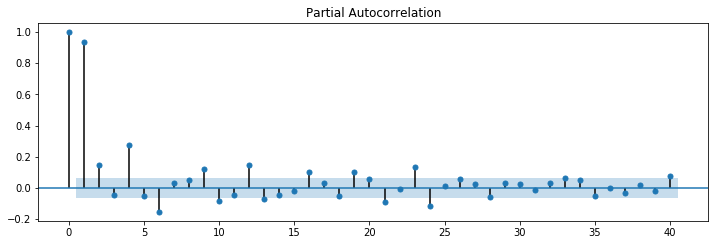

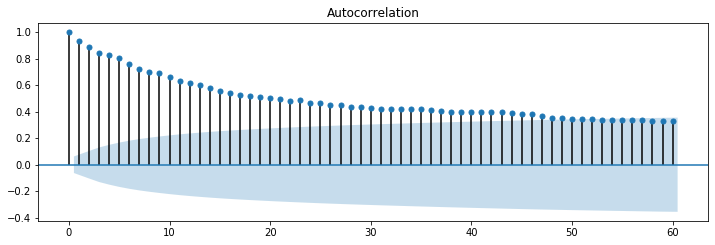

In [37]:
adfuller_test(df3['Bearing1'])

#Shift the dataset to reduce the p-value of the dataset
df3_shift = df3 - df3.shift(1)
df3_shift.dropna(inplace=True)

print("\nAfter shift: \n")
adfuller_test(df3_shift['Bearing1'])
plot_pacf(df3['Bearing1'])
plot_acf(df3['Bearing1'])

The PACF suggests that we use AR=1 for our auto regressive lags, but we found through experimentation that AR=2 yields the better results and is still a small value which helps performance. <br><br>

For the moving average lags we will use the same value. MA=2 as we found it performed the best as well. <br><br>

However, we will be using ar=50, ma=49 because these settings report the lowest RMSE score between the test set and the predictions as we will see later ahead. These settings elevate significantly the cpu usage, training time and prediction time.

### Training the Dataset

In [38]:
import pyflux as pf

t0 = time.time()
cpu_start = psutil.cpu_percent()
print("CPU Usage: \n", cpu_start)

model = pf.ARIMA(data=arima_train, ar=50, ma=49, integ=1, target='Bearing1')
model_fit = model.fit("MLE")

cpu_end = psutil.cpu_percent()
print("\n CPU Usage: ", cpu_end)

print(model_fit.summary())

t1 = time.time()
total_training_time = t1 - t0

print("Seconds taken: ", total_training_time)

CPU Usage: 
 4.3

 CPU Usage:  8.0
Normal ARIMA(50,1,49)                                                                                     
======================================================= ==================================================
Dependent Variable: Differenced Bearing1                Method: MLE                                       
Start Date: 2004-02-12 19:12:00                         Log Likelihood: 3731.7181                         
End Date: 2004-02-17 21:32:00                           AIC: -7261.4362                                   
Number of observations: 734                             BIC: -6796.9868                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0        0.0        0.7066   0.4798   (-0.0001 | 0.0001)       
AR

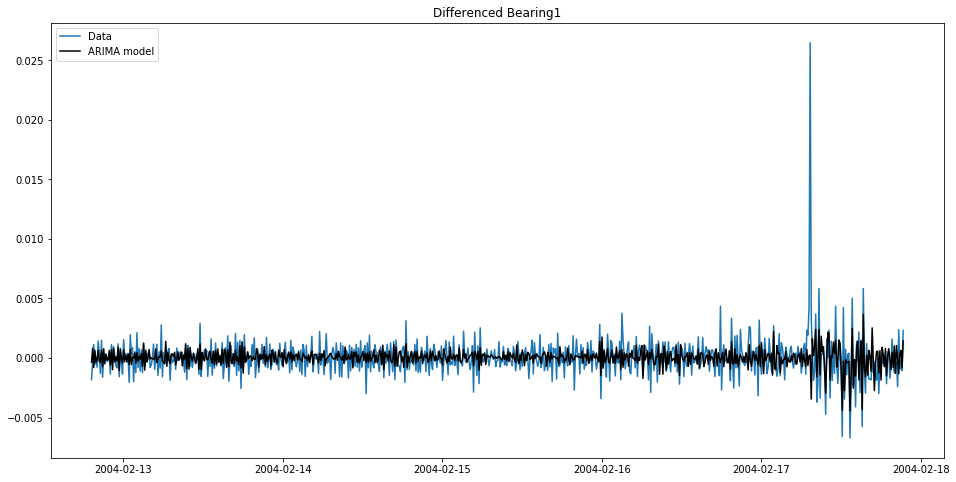

In [39]:
model.plot_fit(figsize=(16,8))
plt.show()

### Predictions

In [40]:
cpu_start_predictions = psutil.cpu_percent()

print("CPU Usage: \n", cpu_start_predictions)
t0 = time.time()

predictions = model.predict(h=197)

cpu_end_predictions = psutil.cpu_percent()
print("\n CPU Usage: ", cpu_end_predictions)

t1 = time.time()
total_prediction_time = t1 - t0

CPU Usage: 
 3.8

 CPU Usage:  8.5


In the plot below we will generate h=196 predictions ahead from our trained model. 

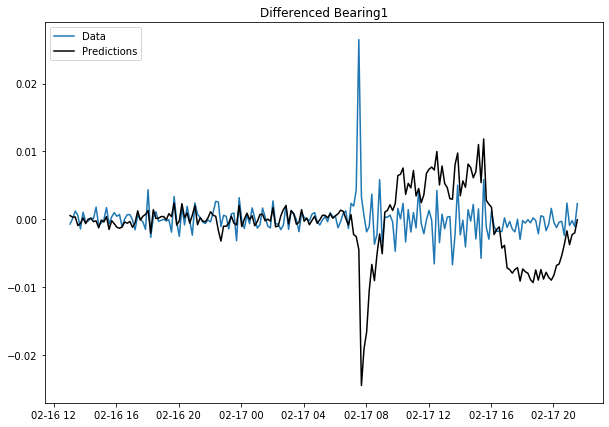

In [41]:
model.plot_predict_is(h=196)
plt.show()

Observation: The data and predicted set are plotted together. We can see that their differences are not very prominent. The peaks around 8 am are the only data points that the model predicts poorly, but overall we can see a pretty good fit. Other particularities of the data, the model seems to predict inversely as well.

In [42]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
test_rmse = np.mean(rmse(arima_test["Bearing1"], predictions))
print(test_rmse)

0.13191539070500866


The previous shortcomings that our model have are less severe when we produce the rmse between the predictions and the test set. This result is much better than if we have had the arima trained with ar=2, ma=2. Even if these other settings would be much faster. <br> However, this ARIMA model is ineffective when predicting anomalies as it either produces them inversely, or otherwise poorly.

# Conclusions

After running both the ARIMA and the Artificial Neural Network, we can compare the performance of both of them, as well as the the accuracy of their models. For the RNN model, the comparison is going to be made using the 70 nodes model from the "Sequential Experiments" section, as it is one of the RNN with the best performance:

In [43]:
dict_df.loc["m_7.0"]

layers           2.000000
nodes           70.000000
train_RMSE       0.001889
test_RMSE        0.032795
train_time      22.298559
predict_time     0.328074
cpu_usage       24.200000
Name: m_7.0, dtype: float64

And the general information for the arima model is the following one:

In [44]:
print("Training time: ", total_training_time)
print("Training CPU usage: ", cpu_end)
print("Testing time: ", total_prediction_time)
print("Testing CPU usage: ", cpu_end_predictions)
print("Testing RMSE: ", test_rmse)

Training time:  95.64962863922119
Training CPU usage:  8.0
Testing time:  0.132033109664917
Testing CPU usage:  8.5
Testing RMSE:  0.13191539070500866


### Train time
By comparing this information we can see that the ANN has the best train time performance. The time taken to train the model was 22.29 seconds in comparison to the 95.64 seconds from the ARIMA model. <br> 
### CPU usage
In terms of cpu usage, the LSTM RNN model used 24% of the CPU, the ARIMA model used 8%. Making the ARIMA model the most efficient. <br> 

### RMSE
Finally, we can confirm that the ANN model is better overall with the use of the root mean square error. With this value we can compare the accuracy of the models and here we can see that the ARIMA model has a much higher value. It has a RMSE of 0.131 while the ANN model has a RMSE of 0.0327 in the testing set.

In conclusion, the model from the LSTM Recurrent Neural Network had a far better performance and accuracy than the ARIMA model in terms of the RMSE and training time. So if we wanted precision and speed, we'd use the network. However if our priority was to use the least cpu consumption we'd have to opt for the ARIMA model.

### Imortant considerations
As a side note, we have to say that our results across all our experiments, settings and models will vary wildly in different computers. And even if we used the same computer, the performance accross the same look_back, number of nodes and layers in a set of networks will vary wildly as well, because the networks use a different weight initialization each time they are ran. We could have set the weights statically, but we wanted to add randomness into our model fabrication. So if you'd ran this notebook multiple times, the neural network the times of the ARIMA would most likely change as well.